# Data Cleaning - Broadband V. Mobile, Coverage, and Mobile Phone Cost

In [38]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patheffects
import numpy as np
import seaborn as sns
import plotly.express as px
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from selenium import webdriver

## Broadband Top 10 Countries

In [2]:
#Import the complete CSV
data_to_load = Path("Resources/Broadband_10.csv")

broadband_ten_data = pd.read_csv(data_to_load)

#Split into two 
broadband_ten_data = broadband_ten_data.iloc[:, :6]

broadband_ten_data.rename(columns={'Top Country': 'Top Broadband Country'}, inplace=True)

#Show
broadband_ten_data


,Top Broadband Country,Broadband Top 10,Place,Number,Lat,Lng
0,China,360.17,1,10,35.000074,104.999927
1,United States,108.89,2,9,39.783730,-100.445882
2,Japan,40.56,3,8,36.574844,139.239418
3,Germany,33.04,4,7,51.163818,10.447831
4,Russia,30.75,5,6,64.686314,97.745306
5,Brazil,29.15,6,5,-10.333333,-53.200000
6,France,28.44,7,4,46.603354,1.888334
7,United Kingdom,26.02,8,3,54.702354,-3.276575
8,South Korea,21.03,9,2,36.638392,127.696119
9,India,18.31,10,1,22.351115,78.667743


### Broadband Top 10

In [41]:
%%capture --no-display
#Hover Cols
hover = ['Top Broadband Country', 'Broadband Top 10', 'Place']

# Configure the map plot
broadband_1 = broadband_ten_data.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "EsriTerrain",
    frame_width = 500,
    frame_height = 300,
    size = "Broadband Top 10",
    scale = 1.5,
    color = "Broadband Top 10",
    cmap='RdYlGn_r',
    title='Broadband Top 10 Countries by Penetration (%)',
    hover_cols = hover
)

# Display the map
broadband_1


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (Broadband Top 10,Top Broadband Country,Place)

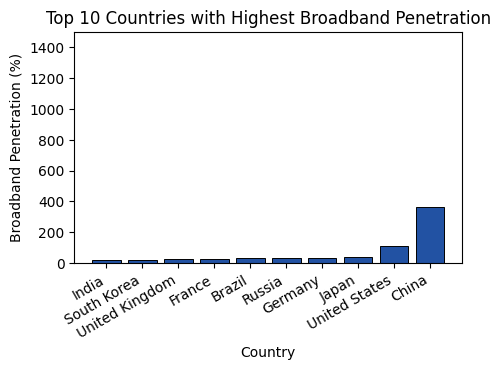

In [20]:
%matplotlib inline
plt.figure(figsize=(5, 3))
broadband_bar = broadband_ten_data.sort_values(by='Broadband Top 10', ascending=True)
ax = plt.bar(broadband_bar['Top Broadband Country'], broadband_bar['Broadband Top 10'], 
             color='#2252a3', alpha=1, linewidth=0.7, edgecolor="black")

# Add labels and title
plt.xlabel('Country')
plt.ylim(0, 1500)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Broadband Penetration (%)')
plt.title('Top 10 Countries with Highest Broadband Penetration')

plt.savefig("Images/Broadband/'broadband10.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

### Mobile Top 10

In [24]:
#Import the complete CSV
data_to_load = Path("Resources/Mobile_10.csv")

mobile_ten_data = pd.read_csv(data_to_load)

#Split into two 
mobile_ten_data = mobile_ten_data.replace({',': ''}, regex=True)
mobile_ten_data = mobile_ten_data.iloc[:, :6]

mobile_ten_data['Mobile Top 10'] = mobile_ten_data['Mobile Top 10'].astype(float)

mobile_ten_data.rename(columns={'Top Country': 'Top Mobile Country'}, inplace=True)

#Show
mobile_ten_data


,Top Mobile Country,Mobile Top 10,Place,Number,Lat,Lng
0,China,1464.27,1,10,35.000074,104.999927
1,India,1136.05,2,9,22.351115,78.667743
2,United States,410.92,3,8,39.783730,-100.445882
3,Indonesia,361.96,4,7,-2.483383,117.890285
4,Russia,235.72,5,6,64.686314,97.745306
5,Brazil,227.95,6,5,-10.333333,-53.200000
6,Japan,172.96,7,4,36.574844,139.239418
7,Nigeria,165.52,8,3,9.600036,7.999972
8,Bangladesh,150.52,9,2,24.476929,90.293441
9,Pakistan,147.97,10,1,30.330840,71.247499


In [25]:
%%capture --no-display
#Hover Cols
hover = ['Top Mobile Country', 'Mobile Top 10', 'Place']

# Configure the map plot
mobile_1 = mobile_ten_data.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "EsriTerrain",
    frame_width = 500,
    frame_height = 300,
    size = "Mobile Top 10",
    scale = 1.5,
    color = "Mobile Top 10",
    cmap='RdYlGn_r',
    title='Mobile Top 10 Data by Penetration (%)',
    hover_cols = hover
)

# Display the map
mobile_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lng,Lat]   (Mobile Top 10,Top Mobile Country,Place)

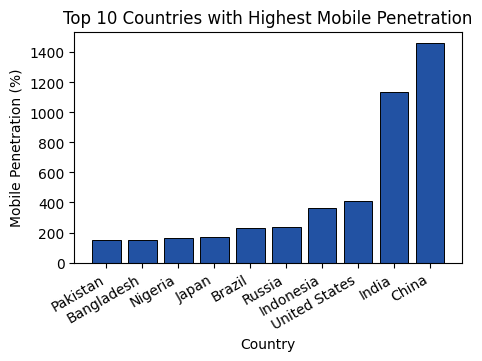

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(5, 3))
mobile_bar = mobile_ten_data.sort_values(by='Mobile Top 10', ascending=True)
ax = plt.bar(mobile_bar['Top Mobile Country'], mobile_bar['Mobile Top 10'], 
             color='#2252a3', alpha=1, linewidth=0.7, edgecolor="black")

# Add labels and title
plt.xlabel('Country')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Mobile Penetration (%)')
plt.title('Top 10 Countries with Highest Mobile Penetration')

# Show the plot
plt.show()
plt.savefig("Images/Broadband/'Mobile10.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

## Top 10 Countries 2g, 3g, and 4g Coverage

In [27]:
#Import the complete CSV
data_to_load = Path("Resources/Coverage.csv")

coverage_data = pd.read_csv(data_to_load)

unwanted_column = ['Unnamed: 0']
coverage_data.drop(columns=unwanted_column, inplace=True)
coverage_data.rename(columns={'2G Coverage': '2G', '3G Coverage': '3G', '4G Coverage': '4G'}, inplace=True)

#Show
coverage_data

,Country,2G,3G,4G
0,China,99.66,98.06,95.86
1,India,96.81,86.76,71.48
2,United States,99.90,99.90,99.76
3,Indonesia,94.36,84.81,62.64
4,Russia,91.98,78.14,65.74
5,Brazil,94.40,94.17,80.46
6,Japan,99.90,99.90,99.00
7,Nigeria,92.33,59.54,17.21
8,Bangladesh,99.51,89.16,71.60
9,Pakistan,87.70,70.92,49.47


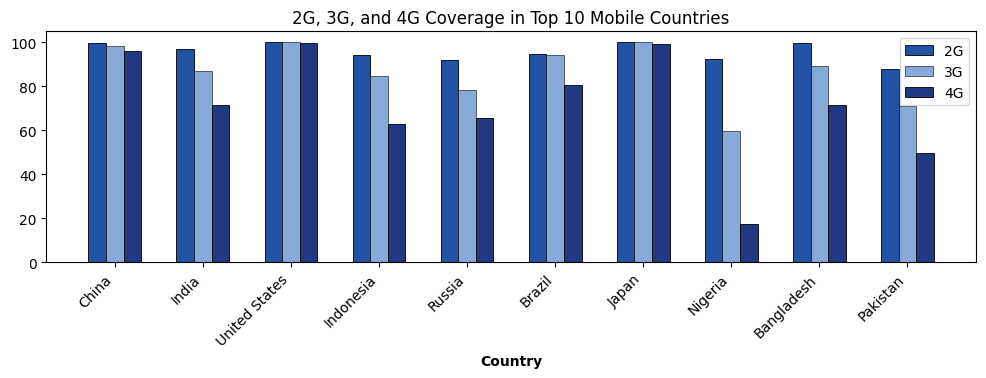

<Figure size 640x480 with 0 Axes>

In [29]:
coverage = pd.DataFrame(coverage_data)
plt.figure(figsize=(12, 3))

# Set up positions for bars on x-axis
bar_width = 0.2

space_between_groups = .0
twog = np.arange(len(coverage))
threeg = [x + bar_width + space_between_groups for x in twog]
fourg = [x + bar_width + space_between_groups for x in threeg]

# Create grouped bar chart
plt.bar(twog, coverage['2G'], width=bar_width, color='#2252A3', linewidth=0.6, edgecolor="Black", label='2G')
plt.bar(threeg, coverage['3G'], width=bar_width, color='#88aad9', linewidth=0.4, edgecolor="Black", label='3G')
plt.bar(fourg, coverage['4G'], width=bar_width, color='#213982', linewidth=0.6, edgecolor="Black", label='4G')

# Customize the plot
plt.xlabel('Country', fontweight='bold')
plt.xticks([r + bar_width + space_between_groups for r in range(len(coverage))], coverage['Country'])
plt.xticks(rotation=45, ha='right')
plt.title('2G, 3G, and 4G Coverage in Top 10 Mobile Countries')
plt.legend()
plt.tick_params(axis='both')

# Show the plot
plt.show()
plt.savefig("Images/Broadband/'coverage.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)

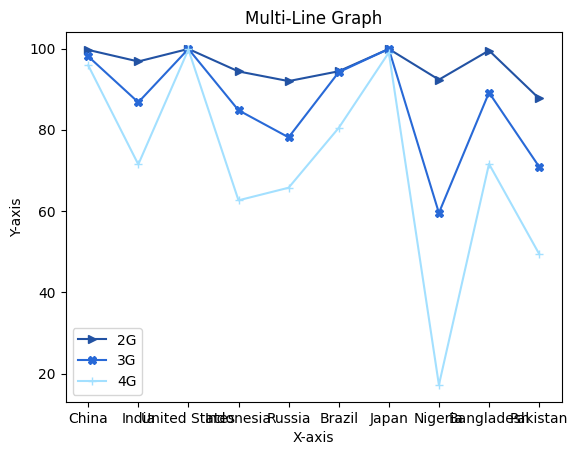

In [149]:
coverage = pd.DataFrame(coverage_data)

# Plot the lines
plt.plot(coverage['Country'], coverage['2G'], label='2G', color='#2252A3', marker='>')
plt.plot(coverage['Country'], coverage['3G'], label='3G', color='#2869D7', marker='X')
plt.plot(coverage['Country'], coverage['4G'], label='4G', color='#A3E0FF', marker='+')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multi-Line Graph')
plt.legend()
    

### Top 10 Countries Cost of Broadband v. Cost of Mobile

In [30]:
#Import the complete CSV
data_to_load = Path("Resources/Cost_comparisons.csv")

cost_data = pd.read_csv(data_to_load)

unwanted_column = ['Unnamed: 0']
cost_data.drop(columns=unwanted_column, inplace=True)
cost_data.rename(columns={'Broadband Cost (% of GNI)': 'Broadband Cost', 
                          'Mobile Cost (% of GNI)': 'Mobile Cost'}, inplace=True)

#Show
cost_data

,Country,Broadband Cost,Mobile Cost
0,China,2.34,0.85
1,India,4.60,2.18
2,United States,0.84,0.15
3,Indonesia,8.94,0.85
4,Russia,0.55,0.24
5,Brazil,2.09,2.18
6,Japan,0.83,1.74
7,Nigeria,14.61,2.43
8,Bangladesh,3.67,3.22
9,Pakistan,5.94,3.32


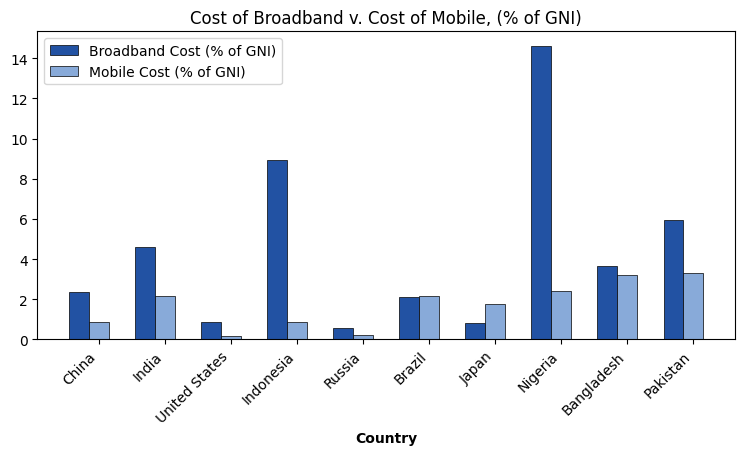

<Figure size 640x480 with 0 Axes>

In [31]:
cost = pd.DataFrame(cost_data)
plt.figure(figsize=(9, 4))

# Set up positions for bars on x-axis
bar_width = 0.3

space_between_groups = 0.0
broadband = np.arange(len(cost))
mobile = [x + bar_width + space_between_groups for x in broadband]

# Create grouped bar chart
plt.bar(broadband, cost['Broadband Cost'], width=bar_width, color='#2252A3', 
        linewidth=0.5, edgecolor="black", label='Broadband Cost (% of GNI)')
plt.bar(mobile, cost['Mobile Cost'], width=bar_width, color='#88aad9', 
        linewidth=0.5, edgecolor="black", label='Mobile Cost (% of GNI)')

# Customize the plot
plt.xlabel('Country', fontweight='bold')
plt.xticks([r + bar_width + space_between_groups for r in range(len(coverage))], coverage['Country'])
plt.xticks(rotation=45, ha='right')
plt.title('Cost of Broadband v. Cost of Mobile, (% of GNI)')
plt.legend()

# Show the plot
plt.show()
plt.savefig("Images/Broadband/'broadband_mobile_cost.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)